# Initialize

In [356]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary

from models.CNN_RNN import RNNWithCNN
from utils.dataset import EEGDataset
from utils.training import best_torch_device, train

In [357]:
# torch.manual_seed(3407)
torch.manual_seed(0)
np.random.seed(0)

In [358]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [359]:
DEVICE = best_torch_device()
RAW = "raw"
SUB1 = "sub1"
FREQ = "frequency"

## Load Data

In [360]:
train_data = {}
valid_data = {}
test_data = {}

### Raw Data

In [361]:
X_train_data = np.load('data/X_train_valid.npy')
y_train_data = np.load('data/y_train_valid.npy')
X_test_data = np.load('data/X_test.npy')
y_test_data = np.load('data/y_test.npy')

split_idx = 1777
X_train_data, X_valid_data = X_train_data[:split_idx], X_train_data[split_idx:]
y_train_data, y_valid_data = y_train_data[:split_idx], y_train_data[split_idx:]

train_set = EEGDataset(X_train_data, y_train_data, label_smoothing=True)
valid_set = EEGDataset(X_valid_data, y_valid_data, label_smoothing=False)
test_set = EEGDataset(X_test_data, y_test_data, label_smoothing=False)

train_data[RAW] = DataLoader(train_set, batch_size=64, shuffle=True)
valid_data[RAW] = DataLoader(valid_set, batch_size=64, shuffle=False)
test_data[RAW] = DataLoader(test_set, batch_size=64, shuffle=False)

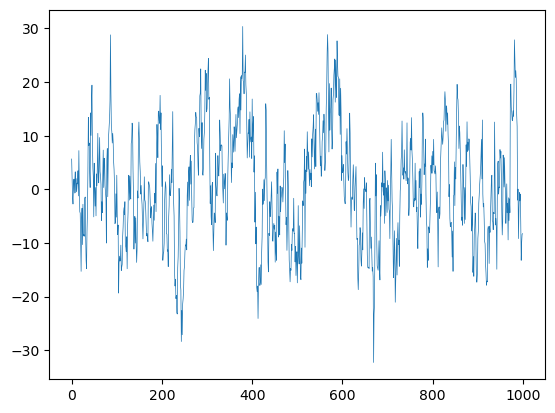

In [362]:
print("Training set shape:", X_train_data.shape, y_train_data.shape)
print("Validation set shape:", X_valid_data.shape, y_valid_data.shape)
print("Test set shape:", X_test_data.shape, y_test_data.shape)

Training set shape: (1777, 22, 1000) (1777,)
Validation set shape: (338, 22, 1000) (338,)
Test set shape: (443, 22, 1000) (443,)


### Sub1 Data

In [363]:
X_train_data = np.load('data/X_train_valid.npy')
y_train_data = np.load('data/y_train_valid.npy')
X_test_data = np.load('data/X_test.npy')
y_test_data = np.load('data/y_test.npy')

split_idx = 1777
X_train_data, X_valid_data = X_train_data[:199], X_train_data[1777:1815]
y_train_data, y_valid_data = y_train_data[:199], y_train_data[1777:1815]

test_person = np.load('data/person_test.npy')
sub0_index = (test_person == 0).reshape(-1)
X_test_data = X_test_data[sub0_index]
y_test_data = y_test_data[sub0_index]

train_set = EEGDataset(X_train_data, y_train_data, label_smoothing=True)
valid_set = EEGDataset(X_valid_data, y_valid_data, label_smoothing=False)
test_set = EEGDataset(X_test_data, y_test_data, label_smoothing=False)

train_data[SUB1] = DataLoader(train_set, batch_size=16, shuffle=True)
valid_data[SUB1] = DataLoader(valid_set, batch_size=16, shuffle=False)
test_data[SUB1] = DataLoader(test_set, batch_size=16, shuffle=False)

In [364]:
print("Training set shape:", X_train_data.shape, y_train_data.shape)
print("Validation set shape:", X_valid_data.shape, y_valid_data.shape)
print("Test set shape:", X_test_data.shape, y_test_data.shape)

Training set shape: (199, 22, 1000) (199,)
Validation set shape: (38, 22, 1000) (38,)
Test set shape: (50, 22, 1000) (50,)


### Frequency Data

In [365]:
X_train_data = np.load('data/generated/frequency/X_train_valid_augmented.npy')
y_train_data = np.load('data/generated/frequency/y_train_valid_augmented.npy')

split_idx = 1777
X_train_data, X_valid_data = X_train_data[:split_idx], X_train_data[split_idx:]
y_train_data, y_valid_data = y_train_data[:split_idx], y_train_data[split_idx:]

train_set = EEGDataset(X_train_data, y_train_data, label_smoothing=True)
valid_set = EEGDataset(X_valid_data, y_valid_data, label_smoothing=False)

train_data[FREQ] = DataLoader(train_set, batch_size=64, shuffle=True)
valid_data[FREQ] = DataLoader(valid_set, batch_size=64, shuffle=False)

In [366]:
print("Training set shape:", X_train_data.shape, y_train_data.shape)
print("Validation set shape:", X_valid_data.shape, y_valid_data.shape)

Training set shape: (1777, 22, 1000) (1777,)
Validation set shape: (4568, 22, 1000) (4568,)


# Model

In [367]:
class RNNWithCNN(nn.Module):
    """
    Combination of RNN and CNN.

    Architecture
    - Input: (N, D, T), D (num of features), T (num of time steps)
    - 1D Convolutions along temporal dimension
        - Conv - ELU - BN - MaxPool - Dropout
    - LSTM's
    - Fully connected layers
    """

    def __init__(
            self,
            num_class: int = 4,
            features_dim: int = 22,
            time_dim: int = 1000,
    ):
        super(RNNWithCNN, self).__init__()

        # CNN
        self.cnn = nn.Sequential(
            nn.LazyConv1d(out_channels=32, kernel_size=8, padding=4),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=64, kernel_size=10, padding=5),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=128, kernel_size=12, padding=6),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=256, kernel_size=14, padding=7),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),
        )

        # Test CNN output
        t = torch.rand(2, features_dim, time_dim)
        t = self.cnn(t)
        rnn_input_size = t.shape[2]

        # self.flatten = nn.Flatten(start_dim=2)

        # RNN
        self.rnn1 = nn.LSTM(
            input_size=rnn_input_size,
            hidden_size=150,
            num_layers=1,
            batch_first=True,
        )
        self.rnn2 = nn.LSTM(
            input_size=150,
            hidden_size=75,
            num_layers=1,
            dropout=0.5,
            batch_first=True,
        )

        # Fully connected layers - 2
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(150),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(num_class),
        )

    def forward(self, x):
        # x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        # x = x.permute(0, 1, 3, 2)

        x = self.cnn(x)
        # x = self.flatten(x)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = self.fc(x)

        # Softmax
        softmax = nn.Softmax(dim=1)
        x = softmax(x)

        return x

In [368]:
test_model = RNNWithCNN()
test_model.forward(torch.rand(2, 22, 1000))
_ = summary(test_model, (22, 1000))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 63]             --
|    └─Conv1d: 2-1                       [-1, 32, 1001]            5,664
|    └─ELU: 2-2                          [-1, 32, 1001]            --
|    └─BatchNorm1d: 2-3                  [-1, 32, 1001]            64
|    └─MaxPool1d: 2-4                    [-1, 32, 500]             --
|    └─Dropout: 2-5                      [-1, 32, 500]             --
|    └─Conv1d: 2-6                       [-1, 64, 501]             20,544
|    └─ELU: 2-7                          [-1, 64, 501]             --
|    └─BatchNorm1d: 2-8                  [-1, 64, 501]             128
|    └─MaxPool1d: 2-9                    [-1, 64, 250]             --
|    └─Dropout: 2-10                     [-1, 64, 250]             --
|    └─Conv1d: 2-11                      [-1, 128, 251]            98,432
|    └─ELU: 2-12                         [-1, 128, 251]            --
|  

# Training

## Raw Data
Train on raw data, evaluate on raw data

In [369]:
raw_model = RNNWithCNN()
raw_model.to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[RAW],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/cnn_rnn",
    cp_filename="raw.pt",
    n_epochs=100,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.352071 train_acc=0.327518 val_loss=0.023702 train_loss=0.021578
Validation loss decreased (inf --> 0.023702).  Saving model ...
[Epoch 1] val_acc=0.431953 train_acc=0.431626 val_loss=0.022760 train_loss=0.020512
Validation loss decreased (0.023702 --> 0.022760).  Saving model ...
[Epoch 2] val_acc=0.505917 train_acc=0.485087 val_loss=0.022258 train_loss=0.019997
Validation loss decreased (0.022760 --> 0.022258).  Saving model ...
[Epoch 3] val_acc=0.449704 train_acc=0.529544 val_loss=0.022316 train_loss=0.019500
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.497041 train_acc=0.581880 val_loss=0.021882 train_loss=0.018989
Validation loss decreased (0.022258 --> 0.021882).  Saving model ...
[Epoch 5] val_acc=0.526627 train_acc=0.616770 val_loss=0.021486 train_loss=0.018729
Validation loss decreased (0.021882 --> 0.021486).  Saving model ...
[Epoch 6] val_acc=0.547337 train_acc=0.633089 val_loss=0.021652 train_loss=0.018394
EarlyStopping count

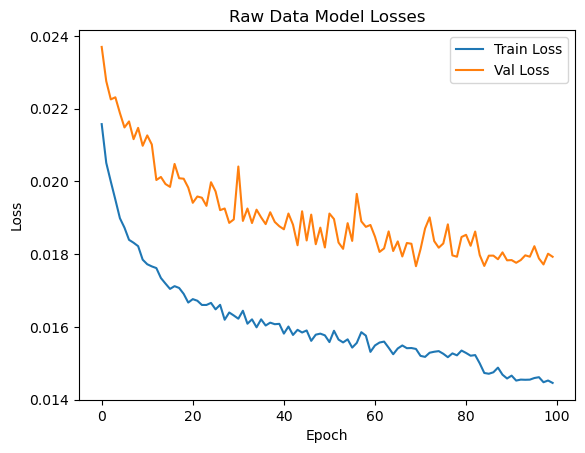

In [370]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

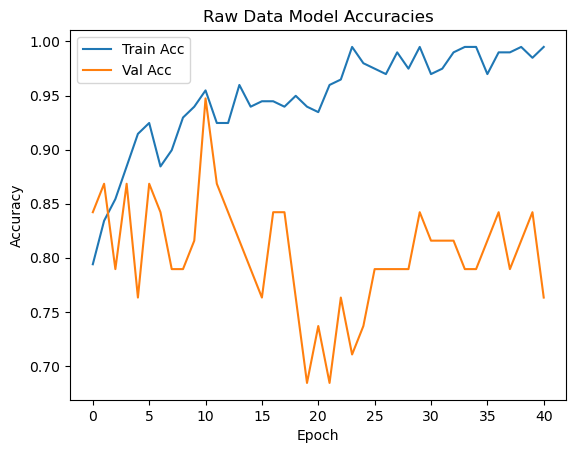

In [380]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [381]:
# Load best model and test
raw_model = torch.load("models/cnn_rnn/raw.pt")
raw_model.to(DEVICE)
raw_model.eval()

RNNWithCNN(
  (cnn): Sequential(
    (0): Conv1d(22, 32, kernel_size=(8,), stride=(1,), padding=(4,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(32, 64, kernel_size=(10,), stride=(1,), padding=(5,))
    (6): ELU(alpha=1.0)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv1d(64, 128, kernel_size=(12,), stride=(1,), padding=(6,))
    (11): ELU(alpha=1.0)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv1d(128, 256, kernel_size=(14,

In [382]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.7156


In [383]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.6400


## Sub1 Data    

In [384]:
sub1_model = RNNWithCNN()
sub1_model.to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[SUB1],
    val_data=valid_data[SUB1],
    early_stopping_patience=30,
    cp_path="models/cnn_rnn",
    cp_filename="sub1.pt",
    n_epochs=80,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.763158 train_acc=0.849246 val_loss=0.075258 train_loss=0.063757
Validation loss decreased (inf --> 0.075258).  Saving model ...
[Epoch 1] val_acc=0.815789 train_acc=0.824121 val_loss=0.071761 train_loss=0.065529
Validation loss decreased (0.075258 --> 0.071761).  Saving model ...
[Epoch 2] val_acc=0.842105 train_acc=0.874372 val_loss=0.073362 train_loss=0.061822
EarlyStopping counter: 1 out of 30
[Epoch 3] val_acc=0.763158 train_acc=0.889447 val_loss=0.079617 train_loss=0.062426
EarlyStopping counter: 2 out of 30
[Epoch 4] val_acc=0.763158 train_acc=0.924623 val_loss=0.077548 train_loss=0.059963
EarlyStopping counter: 3 out of 30
[Epoch 5] val_acc=0.657895 train_acc=0.894472 val_loss=0.082660 train_loss=0.061223
EarlyStopping counter: 4 out of 30
[Epoch 6] val_acc=0.710526 train_acc=0.904523 val_loss=0.078571 train_loss=0.060444
EarlyStopping counter: 5 out of 30
[Epoch 7] val_acc=0.763158 train_acc=0.889447 val_loss=0.075303 train_loss=0.061989
Ea

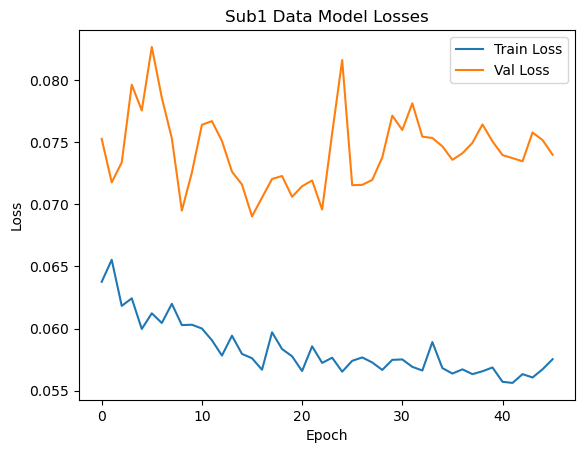

In [385]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

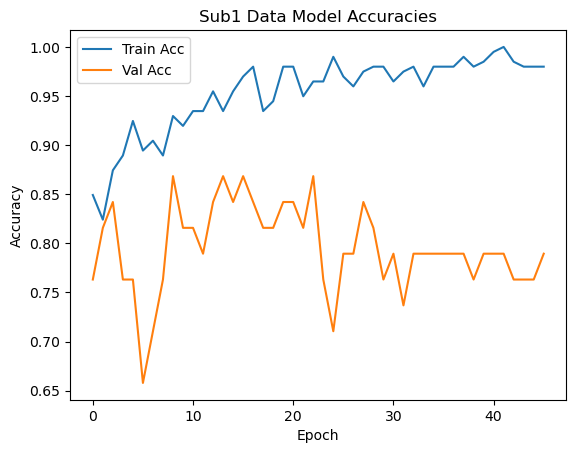

In [386]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [387]:
# Load best model and test
sub1_model = torch.load("models/cnn_rnn/sub1.pt")
sub1_model.to(DEVICE)
sub1_model.eval()

RNNWithCNN(
  (cnn): Sequential(
    (0): Conv1d(22, 32, kernel_size=(8,), stride=(1,), padding=(4,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(32, 64, kernel_size=(10,), stride=(1,), padding=(5,))
    (6): ELU(alpha=1.0)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv1d(64, 128, kernel_size=(12,), stride=(1,), padding=(6,))
    (11): ELU(alpha=1.0)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv1d(128, 256, kernel_size=(14,

In [388]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.7400


In [389]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on sub1 data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on raw data
Test Acc: 0.5576


## Frequency Data

In [399]:
freq_model = RNNWithCNN()
freq_model.to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[FREQ],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/cnn_rnn",
    cp_filename="freq.pt",
    n_epochs=100,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.701183 train_acc=0.869443 val_loss=0.018746 train_loss=0.015108
Validation loss decreased (inf --> 0.018746).  Saving model ...
[Epoch 1] val_acc=0.710059 train_acc=0.872257 val_loss=0.018117 train_loss=0.015107
Validation loss decreased (0.018746 --> 0.018117).  Saving model ...
[Epoch 2] val_acc=0.718935 train_acc=0.883512 val_loss=0.017918 train_loss=0.014944
Validation loss decreased (0.018117 --> 0.017918).  Saving model ...
[Epoch 3] val_acc=0.715976 train_acc=0.882949 val_loss=0.018243 train_loss=0.014997
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.701183 train_acc=0.890827 val_loss=0.018174 train_loss=0.014853
EarlyStopping counter: 2 out of 30
[Epoch 5] val_acc=0.701183 train_acc=0.885763 val_loss=0.018264 train_loss=0.014920
EarlyStopping counter: 3 out of 30
[Epoch 6] val_acc=0.724852 train_acc=0.885200 val_loss=0.017976 train_loss=0.014956
EarlyStopping counter: 4 out of 30
[Epoch 7] val_acc=0.754438 train_acc=0.873382 val_lo

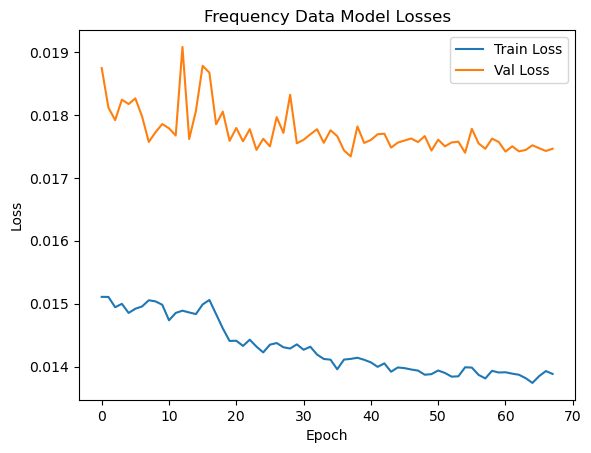

In [400]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Frequency Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

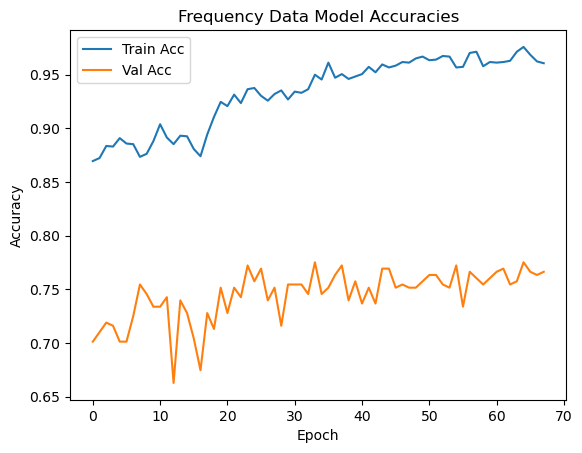

In [401]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Frequency Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [402]:
# Load best model and test
freq_model = torch.load("models/cnn_rnn/freq.pt")
freq_model.to(DEVICE)
freq_model.eval()

RNNWithCNN(
  (cnn): Sequential(
    (0): Conv1d(22, 32, kernel_size=(8,), stride=(1,), padding=(4,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(32, 64, kernel_size=(10,), stride=(1,), padding=(5,))
    (6): ELU(alpha=1.0)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv1d(64, 128, kernel_size=(12,), stride=(1,), padding=(6,))
    (11): ELU(alpha=1.0)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv1d(128, 256, kernel_size=(14,

In [403]:
# Evaluate on frequency data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = freq_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on frequency data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on frequency data, evaluate on raw data
Test Acc: 0.7540
